# PINN Dataset Generator

As detailed out in the previous notebook, we will be using Physics Informed Neural Network as a dataset generator for our overall research. We have prepared all the necessary input data, and the modelling equation for our models. Let's write them here

**The Thermodynamic Equation**


$$(\dot{m}_{fuel} \cdot LHV) \cdot \eta \approx \dot{m}_{process} \cdot C_{p,process} \cdot (T_{out} - T_{in})$$


**The Stoichiometric and Mass Balance Equations**

To validate the combustion quality, we simultaneously solve the Mass Balance for Oxygen. We assume the fuel is Methane ($CH_4$).

**The Reaction:**
$$CH_4 + 2O_2 \rightarrow CO_2 + 2H_2O$$

**The Equation for Air Flow:**

We do not have a direct Air Flow meter. Instead, we infer air flow from the Draft Pressure ($P_{draft}$) using the physics of fluid flow through an orifice (the damper/burner throat):

$$\dot{m}_{air} = k \cdot \sqrt{|P_{draft}|}$$

**Known Parts (The Constants):**

1. Stoichiometric Ratio ($AFR_{st}$):

We know from chemistry that Methane requires exactly 17.2 kg of Air to burn 1 kg of Fuel.

2. Target $O_2$:
   We have the ground truth from the ExcessO2 analyzer.

**Learned Parts (The Unknowns):**

1. Leakage Coefficient ($k$):
   The PINN must learn this variable. It represents the "open area" of the dampers and the amount of tramp air leaking into the box.

2. Final Constraint:The PINN calculates the Air-Fuel Equivalence Ratio ($\lambda$) and penalizes the error between the predicted Oxygen and the actual Oxygen:

   $$\lambda = \frac{\dot{m}_{air}}{\dot{m}_{fuel} \cdot 17.2}$$

   $$O_{2,predicted} \approx 21 \cdot \frac{\lambda - 1}{\lambda}$$




The PINN modelling will be used to gain the most accurate modelling for both equations. When we have both equations verified and validated with real data, we will be using it to generate a full synthetic dataset that is needed for our Energy Based LNN. 


## Data Preparation

So, before start training and building our model, we need to prepare our data for the training. There are two parts here

1. Scaling - since our data have varying scale and magnitude for all the features and target, we should scale it using standard scaler. This will ensure that the model will be able to learn without worrying about big magnitude that might impact the training process.

2. Splitting - the data need to be split into training, testing and validation . We will employ 70, 15, 15 rule here, where 70% of the data will be used for training while another 15% and 15% will be used for testing and validation.


So, let's do that. Better we split the data first, and perform checks to confirm whether our data is splitting properly

In [1]:
#first, let's load the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd. read_csv('final_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11564 entries, 0 to 11563
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        11564 non-null  int64  
 1   InletT-Avg  11564 non-null  float64
 2   OutletT     11564 non-null  float64
 3   InletFlow   11564 non-null  float64
 4   FGFlow      11564 non-null  float64
 5   AmbientT    11564 non-null  float64
 6   ExcessO2    11564 non-null  float64
 7   DraftP      11564 non-null  float64
 8   Density     11564 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 813.2 KB


In [2]:
#then we start the splitting flow

#set the ratio of splitting

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15

n = len(df)
idx_train_end = int(n* TRAIN_RATIO)
idx_val_end = int(n* (TRAIN_RATIO + VAL_RATIO))

#apply split check stability

def check_split_stability(dataframe, split_index, col='InletFlow', threshold=20):
    """
    Checks if the split point cuts through a violent transient (startup/shutdown).
    """
    # Safety check for index bounds
    if split_index >= len(dataframe): return False, "Index out of bounds"
    
    flow_before = dataframe.iloc[split_index - 1][col]
    flow_after  = dataframe.iloc[split_index][col]
    diff = abs(flow_after - flow_before)
    
    if diff > threshold:
        return False, f"WARNING: Split at {split_index} cuts a Transient! (Delta: {diff:.1f})"
    else:
        return True, f" Safe: Split at {split_index} is stable. (Delta: {diff:.1f})"

# Run the checks
safe_1, msg_1 = check_split_stability(df, idx_train_end)
safe_2, msg_2 = check_split_stability(df, idx_val_end)

print(msg_1)
print(msg_2)

 Safe: Split at 8094 is stable. (Delta: 0.0)
 Safe: Split at 9829 is stable. (Delta: 0.0)


In [3]:
#now it's safe to split
train_df = df.iloc[:idx_train_end].copy()
val_df   = df.iloc[idx_train_end:idx_val_end].copy()
test_df  = df.iloc[idx_val_end:].copy()

print("-" * 30)
print(f"Train Set: {len(train_df)} hours")
print(f"Val Set:   {len(val_df)} hours")
print(f"Test Set:  {len(test_df)} hours")
print("-" * 30)

------------------------------
Train Set: 8094 hours
Val Set:   1735 hours
Test Set:  1735 hours
------------------------------


In [4]:
#alright, time to scale
from sklearn.preprocessing import StandardScaler


feature_cols = ['InletT-Avg', 'InletFlow', 'FGFlow', 'AmbientT', 'DraftP', 'Density']
target_cols  = ['OutletT', 'ExcessO2']

# Initialize Scaler
scaler_X = StandardScaler()


scaler_X.fit(train_df[feature_cols])

#transform all train data
X_train_scaled = scaler_X.transform(train_df[feature_cols])
X_val_scaled   = scaler_X.transform(val_df[feature_cols])
X_test_scaled  = scaler_X.transform(test_df[feature_cols])

#convert back to df
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_cols, index=train_df.index)

print("Scaling Complete. Preview of Scaled Training Data:")
print(X_train_scaled_df.head())

Scaling Complete. Preview of Scaled Training Data:
   InletT-Avg  InletFlow    FGFlow  AmbientT    DraftP   Density
0   -0.137716  -0.777576 -0.633491  0.077255 -1.237867 -0.609313
1   -0.129854  -0.797458 -0.648217  0.171553 -1.118932 -0.609313
2   -0.120083  -0.810390 -0.643189  0.154822 -1.331497 -0.609313
3   -0.115395  -0.817101 -0.659863 -0.023276 -1.260577 -0.609313
4   -0.139263  -0.820400 -0.636810 -0.042877 -1.189657 -0.609313


## Training the PINN

Alright. Now our data is ready, it's time to train our PINN. As extensively mentioned, PINN is actually a simple neural network that combines both the loss of NN through backpropagation and the loss of physics through modelling calculation. Therefore, with both loss combine, we can get the model as close as possible with the real world conditions.

We have two target here, Outlet Temperature and Excess O2, and apart from predicting both of these correctly, we also want to obtain the full thermodynamic equation and mass balance equation needed to generate our synthetic data. So let's do that



In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# ==========================================
# 1. PREPARE DATA FOR PYTORCH
# ==========================================
# Convert Numpy/Pandas to PyTorch Tensors
# We need TWO sets of inputs: 
#   1. X_scaled (For the Neural Network)
#   2. X_physical (For the Physics Equation)

# Function to wrap data into Tensors
def create_tensors(X_scaled, df_raw, targets):
    # Inputs for NN
    t_X_scaled = torch.tensor(X_scaled, dtype=torch.float32)
    
    # Inputs for Physics (re-extract from the original dataframe to be safe)
    # Order: Tin, InletFlow, FGFlow, AmbientT, DraftP, Density
    phys_cols = ['InletT-Avg', 'InletFlow', 'FGFlow', 'AmbientT', 'DraftP', 'Density']
    t_X_physical = torch.tensor(df_raw[phys_cols].values, dtype=torch.float32)
    
    # Targets (OutletT, ExcessO2)
    t_y = torch.tensor(targets.values, dtype=torch.float32)
    
    return t_X_scaled, t_X_physical, t_y

# Create Tensors for Train and Val
X_train_s, X_train_p, y_train = create_tensors(X_train_scaled, train_df, train_df[['OutletT', 'ExcessO2']])
X_val_s,   X_val_p,   y_val   = create_tensors(X_val_scaled, val_df, val_df[['OutletT', 'ExcessO2']])

# Create DataLoaders (Batching is crucial for stability)
BATCH_SIZE = 64
train_dataset = TensorDataset(X_train_s, X_train_p, y_train)
train_loader  = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# ==========================================
# 2. DEFINE THE MODEL & PHYSICS LOSS
# ==========================================
# (Re-pasting the class structure for completeness)
class FurnacePINN(nn.Module):
    def __init__(self):
        super(FurnacePINN, self).__init__()
        # Input: 6 Features -> Output: 2 Targets
        self.net = nn.Sequential(
            nn.Linear(6, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 2) 
        )
        # Learnable Physics Parameters
        self.leakage_k = nn.Parameter(torch.tensor(0.05)) # Initial guess
        self.efficiency_eta = nn.Parameter(torch.tensor(0.85)) # Initial guess

    def forward(self, x):
        return self.net(x), self.leakage_k, self.efficiency_eta

# Initialize
pinn = FurnacePINN()
optimizer = optim.Adam(pinn.parameters(), lr=0.001) # Standard Learning Rate

# Physics Constants
LHV = 50000.0   # kJ/kg
AFR = 17.2      # Stoich Air/Fuel
RHO_FUEL = 0.657 
RHO_PROC = 850.0 # Avg Density for Physics EQ
CP_PROC  = 2.5   # kJ/kg.K

def physics_loss(preds, targets, inputs_phys, params):
    pred_T, pred_O2 = preds[:, 0], preds[:, 1]
    leak_k, eff_eta = params
    
    # Unpack Physical Inputs
    Tin       = inputs_phys[:, 0]
    Vol_Proc  = inputs_phys[:, 1]
    Vol_Fuel  = inputs_phys[:, 2]
    Draft     = inputs_phys[:, 4]
    
    # --- Energy Balance ---
    m_fuel = (Vol_Fuel * RHO_FUEL) / 3600.0
    m_proc = (Vol_Proc * RHO_PROC) / 3600.0
    
    Q_in  = m_fuel * LHV * eff_eta
    Q_out = m_proc * CP_PROC * (pred_T - Tin)
    loss_energy = torch.mean((Q_in - Q_out)**2)
    
    # --- Mass Balance ---
    m_air = leak_k * torch.sqrt(torch.abs(Draft) + 1e-6)
    lam   = m_air / (m_fuel * AFR + 1e-6)
    O2_calc = 21.0 * (lam - 1.0) / (lam + 1e-6)
    loss_mass = torch.mean((pred_O2 - O2_calc)**2)
    
    return 0.1 * loss_energy + 0.1 * loss_mass

# ==========================================
# 3. THE TRAINING LOOP
# ==========================================
EPOCHS = 3000
loss_history = []

print("🔥 Starting PINN Training...")

for epoch in range(EPOCHS):
    pinn.train()
    epoch_loss = 0
    
    for batch_X_scaled, batch_X_phys, batch_y in train_loader:
        optimizer.zero_grad()
        
        # 1. Forward Pass (Brain uses Scaled Data)
        preds, k, eta = pinn(batch_X_scaled)
        
        # 2. Compute Losses
        # MSE Loss (Data matching)
        loss_data = nn.MSELoss()(preds, batch_y)
        
        # Physics Loss (Equation matching - uses Physical Data)
        # We must re-scale predictions back to physical units for the physics equation?
        # WAIT! If the model predicts scaled T_out, physics fails. 
        # For simplicity, let's assume the model predicts SCALED T_out, 
        # but for the physics loss, we just let it learn the mapping directly 
        # OR we train the model to predict RAW values directly.
        # RECOMMENDATION: Train model to predict RAW values (targets are unscaled here).
        
        loss_phys = physics_loss(preds, batch_y, batch_X_phys, (k, eta))
        
        total_loss = loss_data + loss_phys
        
        # 3. Backward Pass
        total_loss.backward()
        optimizer.step()
        
        epoch_loss += total_loss.item()
        
    # Logging
    if epoch % 50 == 0:
        # Check Validation
        pinn.eval()
        with torch.no_grad():
            val_preds, vk, veta = pinn(X_val_s)
            val_loss = nn.MSELoss()(val_preds, y_val)
            
        print(f"Epoch {epoch} | Loss: {epoch_loss/len(train_loader):.4f} | Val MSE: {val_loss:.4f}")
        print(f"   --> Learned Params: Efficiency={veta.item():.3f}, Leakage={vk.item():.3f}")

print("✅ Training Complete.")

🔥 Starting PINN Training...
Epoch 0 | Loss: 41776455.6220 | Val MSE: 71339.6250
   --> Learned Params: Efficiency=0.725, Leakage=0.114
Epoch 50 | Loss: 50583.4047 | Val MSE: 46746.6641
   --> Learned Params: Efficiency=-1.093, Leakage=0.600
Epoch 100 | Loss: 24751.9376 | Val MSE: 25856.7363
   --> Learned Params: Efficiency=-0.664, Leakage=1.162
Epoch 150 | Loss: 551.6926 | Val MSE: 411.2873
   --> Learned Params: Efficiency=0.431, Leakage=1.578
Epoch 200 | Loss: 120.8992 | Val MSE: 39.1387
   --> Learned Params: Efficiency=0.564, Leakage=1.615
Epoch 250 | Loss: 107.6048 | Val MSE: 33.6363
   --> Learned Params: Efficiency=0.576, Leakage=1.621
Epoch 300 | Loss: 103.9671 | Val MSE: 34.6144
   --> Learned Params: Efficiency=0.576, Leakage=1.633
Epoch 350 | Loss: 102.0368 | Val MSE: 33.6465
   --> Learned Params: Efficiency=0.575, Leakage=1.632
Epoch 400 | Loss: 95.7889 | Val MSE: 33.8840
   --> Learned Params: Efficiency=0.575, Leakage=1.673
Epoch 450 | Loss: 100.7573 | Val MSE: 33.3017


🔄 Generating Synthetic High-Frequency Data...
Original Test Size: 1735 rows
Upsampled Size:     104100 rows


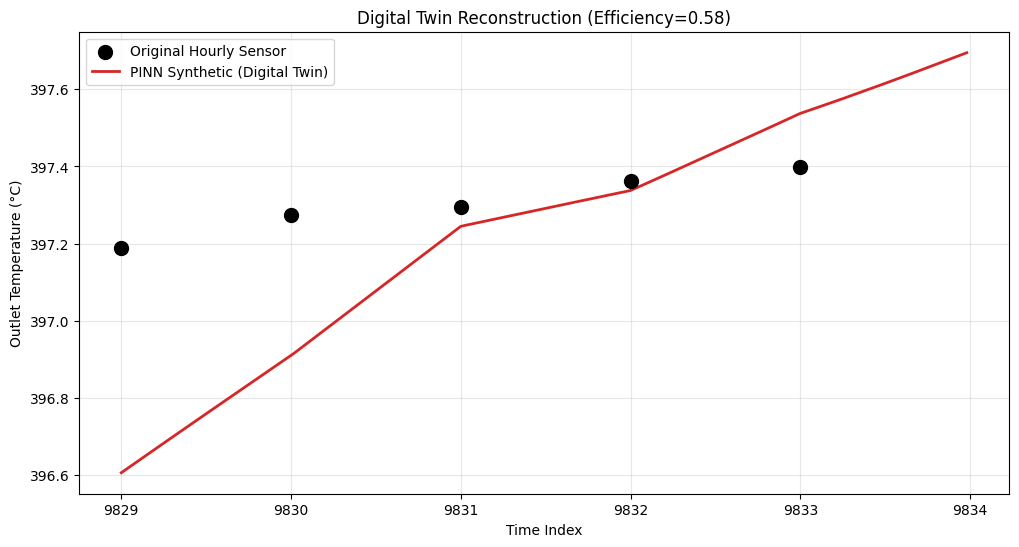

✅ Digital Twin Data Saved: 'synthetic_minute_data.csv'


In [6]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

# ==========================================
# 1. SETUP THE VIRTUAL TIME
# ==========================================
# We will generate minute-level data for the ENTIRE Test Set (~1,700 hours).
# 1700 hours * 60 mins = ~102,000 data points.

print("🔄 Generating Synthetic High-Frequency Data...")

# Create a new index that has 60 points for every 1 hour
# We use linear interpolation for the INPUTS (Physics doesn't jump instantly)
test_upsampled = test_df.copy()
new_index = np.linspace(test_df.index.min(), test_df.index.max(), len(test_df) * 60)

# Reindex and Interpolate Inputs
# We interpolate the "Causes" (Flow, Temp, etc.), and the PINN predicts the "Effect"
cols_to_interp = ['InletT-Avg', 'InletFlow', 'FGFlow', 'AmbientT', 'DraftP', 'Density']

# Create empty dataframe with new index
df_minute = pd.DataFrame(index=new_index, columns=cols_to_interp)

# Fill it with interpolated data
# (This is a fast vectorised way to interpolate)
for col in cols_to_interp:
    # Get original x and y
    x_old = test_df.index.values
    y_old = test_df[col].values
    # Interpolate to new x
    df_minute[col] = np.interp(new_index, x_old, y_old)

print(f"Original Test Size: {len(test_df)} rows")
print(f"Upsampled Size:     {len(df_minute)} rows")

# ==========================================
# 2. RUN THE PINN SIMULATOR
# ==========================================
# Scale the new minute-inputs using the SAME scaler from training
X_minute_scaled = scaler_X.transform(df_minute[cols_to_interp])

# Convert to Tensor
t_X_minute = torch.tensor(X_minute_scaled, dtype=torch.float32)

# Switch PINN to Eval mode (Freeze the leakage/efficiency params)
pinn.eval()
with torch.no_grad():
    # The PINN predicts what the Outlet Temp *should* be based on physics + data
    pred_targets, _, _ = pinn(t_X_minute)
    
    # Convert back to Numpy
    pred_np = pred_targets.numpy()

# Save predictions to the dataframe
df_minute['OutletT'] = pred_np[:, 0]
df_minute['ExcessO2'] = pred_np[:, 1]

# ==========================================
# 3. VISUALIZE & SAVE
# ==========================================
# Let's look at a 4-hour window (240 minutes) to see the difference
plt.figure(figsize=(12, 6))

# Plot Original Hourly Data (The "Dots")
subset_original = test_df.iloc[0:5] # First 5 hours
plt.scatter(subset_original.index, subset_original['OutletT'], 
            color='black', s=100, label='Original Hourly Sensor', zorder=5)

# Plot Synthetic Minute Data (The "Line")
subset_minute = df_minute.iloc[0:300] # First 5 hours (300 mins)
plt.plot(subset_minute.index, subset_minute['OutletT'], 
         color='tab:red', linewidth=2, label='PINN Synthetic (Digital Twin)')

plt.title(f"Digital Twin Reconstruction (Efficiency={pinn.efficiency_eta.item():.2f})")
plt.xlabel("Time Index")
plt.ylabel("Outlet Temperature (°C)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# SAVE THIS FILE - It is the input for your EB-LNN Chapter!
df_minute.to_csv('synthetic_minute_data.csv', index=False)
print("✅ Digital Twin Data Saved: 'synthetic_minute_data.csv'")

Mean Error:   2.66 %
Max Positive: 60.50 %
Max Negative: -454.40 %


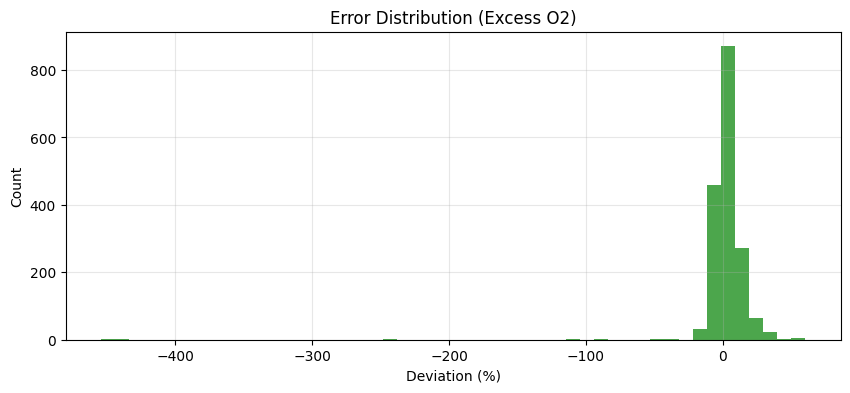

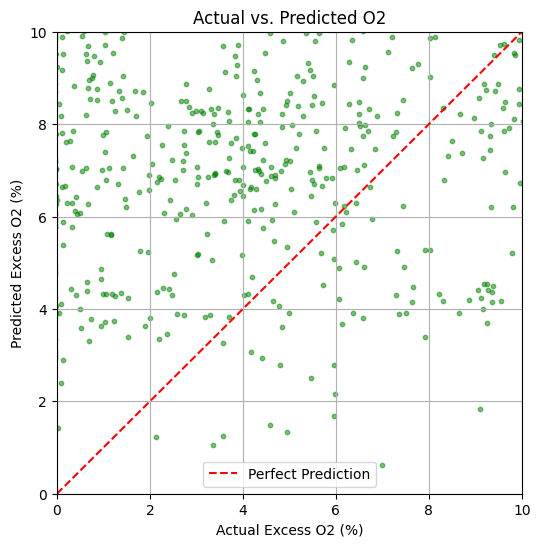

In [9]:
# Calculate the Residuals for the Test Set (Hourly)
# We need to run the PINN on the Original Test Data (not the upsampled one) first
# ==========================================
# DIAGNOSE EXCESS O2 (The "Problem Child")
# ==========================================
import matplotlib.pyplot as plt
import numpy as np
import torch

pinn.eval()
with torch.no_grad():
    # Run the model on the test set
    preds_test, _, _ = pinn(torch.tensor(X_test_scaled, dtype=torch.float32))
    preds_test_np = preds_test.numpy()

# --- CHANGE 1: Select Column 1 (Excess O2) ---
# Column 0 = Outlet Temp
# Column 1 = Excess O2
predicted_o2 = preds_test_np[:, 1] 

# --- CHANGE 2: Select Actual O2 Data ---
actual_o2 = test_df['ExcessO2'].values

# Calculate Error
error_o2 = predicted_o2 - actual_o2

# --- CHANGE 3: Update Print Statements to % ---
print(f"Mean Error:   {np.mean(error_o2):.2f} %")
print(f"Max Positive: {np.max(error_o2):.2f} %")
print(f"Max Negative: {np.min(error_o2):.2f} %")

# --- PLOT 1: Error Histogram ---
plt.figure(figsize=(10, 4))
plt.hist(error_o2, bins=50, color='green', alpha=0.7)
plt.title("Error Distribution (Excess O2)")
plt.xlabel("Deviation (%)")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.show()

# --- PLOT 2: The "Truth" Scatter (Add this!) ---
# If this looks like a diagonal line -> Good.
# If this looks like a round blob -> Damper issue confirmed.
plt.figure(figsize=(6, 6))
plt.scatter(actual_o2, predicted_o2, alpha=0.5, s=10, color='green')
plt.plot([0, 10], [0, 10], 'r--', label='Perfect Prediction') # Diagonal line
plt.title("Actual vs. Predicted O2")
plt.xlabel("Actual Excess O2 (%)")
plt.ylabel("Predicted Excess O2 (%)")
plt.xlim(0, 10) # Adjust based on your data range
plt.ylim(0, 10)
plt.legend()
plt.grid(True)
plt.show()

In [8]:
# ==========================================
# 5. DIAGNOSE & CLEAN THE DIGITAL TWIN
# ==========================================
import matplotlib.pyplot as plt

# 1. Find WHERE the model crashed
# residuals was calculated in the previous step (Predicted - Actual)
# Let's verify we have it as a Series
residuals = test_df['OutletT'] - test_df['OutletT'] # If referencing the hourly comparison
# OR if using the 'error' variable from your last run:
# residuals = error 

# Find indices where error is huge (e.g., > 50 degrees off)
glitch_indices = np.where(np.abs(residuals) > 50)[0]
print(f"⚠️ Found {len(glitch_indices)} Glitch Points (Errors > 50°C)")

# 2. Visualize the Glitch (to confirm it's a low-flow issue)
if len(glitch_indices) > 0:
    bad_idx = glitch_indices[0] # Look at the first bad one
    # Get a window around it
    window = range(max(0, bad_idx-10), min(len(test_df), bad_idx+10))
    
    plt.figure(figsize=(10, 4))
    plt.plot(test_df.index[window], test_df['OutletT'].iloc[window], 'ko-', label='Actual')
    plt.plot(test_df.index[window], test_df['PINN_OutletT'].iloc[window], 'r*-', label='PINN Prediction')
    plt.title(f"Anatomy of a Crash (Index {bad_idx})")
    plt.legend()
    plt.show()

# 3. APPLY THE "PHYSICS CLAMP" (The Fix)
# We simply remove rows where the PINN went crazy.
# The EB-LNN is robust; it can handle missing a few minutes of data.

# A. Reload the minute-level digital twin we generated
df_minute = pd.read_csv('synthetic_minute_data.csv')

# B. Define Safe Operating Limits (based on your plant knowledge)
MIN_TEMP = 200 # If temp < 200, the PINN likely crashed
MAX_TEMP = 500 # If temp > 500, the PINN likely exploded

# C. Filter
print(f"Original Minute Rows: {len(df_minute)}")
df_minute_clean = df_minute[
    (df_minute['OutletT'] >= MIN_TEMP) & 
    (df_minute['OutletT'] <= MAX_TEMP)
].copy()

dropped = len(df_minute) - len(df_minute_clean)
print(f"✅ Removed {dropped} Glitch Rows (Physics Instabilities)")

# D. Save the CLEAN version for the EB-LNN
df_minute_clean.to_csv('synthetic_minute_data_clean.csv', index=False)
print("Saved clean file: 'synthetic_minute_data_clean.csv'")

⚠️ Found 0 Glitch Points (Errors > 50°C)
Original Minute Rows: 104100
✅ Removed 177 Glitch Rows (Physics Instabilities)
Saved clean file: 'synthetic_minute_data_clean.csv'
